<a href="https://colab.research.google.com/github/Txlu-OG/AI-Project/blob/main/AI_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Data Collection and Initial Analysis of Stock Market Data
Author: Adedamola Ogundipe

This notebook performs advanced data cleaning, transformation, and preparation on the **Daily Historical Stock Prices (1970–2018)** dataset.

The main steps are:
1. Load and inspect data
2. Advanced data cleaning (missing values, outliers, errors)
3. Feature engineering (returns, rolling averages, volatility, etc.)
4. Encoding categorical variables
5. Scaling and time-based train/validation/test split
6. Saving cleaned datasets for future modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# 1. Configuration
STOCKS_PATH = Path("/content/drive/MyDrive/Daily Historical Stock Prices (1970 - 2018)/historical_stocks.csv")
PRICES_PATH = Path("/content/drive/MyDrive/Daily Historical Stock Prices (1970 - 2018)/historical_stock_prices.csv")

# Directory to save figures
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

In [3]:
# 2. Data loading
print("Loading data...")

stocks = pd.read_csv(STOCKS_PATH)
prices = pd.read_csv(PRICES_PATH)

# Normalize column names to lower-case to avoid case issues
stocks.columns = [c.lower() for c in stocks.columns]
prices.columns = [c.lower() for c in prices.columns]

print("\nStocks columns:", stocks.columns)
print("Prices columns:", prices.columns)
print("\nSample stocks rows:")
print(stocks.head())
print("\nSample prices rows:")
print(prices.head())

Loading data...

Stocks columns: Index(['ticker', 'exchange', 'name', 'sector', 'industry'], dtype='object')
Prices columns: Index(['ticker', 'open', 'close', 'adj_close', 'low', 'high', 'volume',
       'date'],
      dtype='object')

Sample stocks rows:
  ticker exchange                                    name             sector  \
0    PIH   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
1  PIHPP   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
2   TURN   NASDAQ                180 DEGREE CAPITAL CORP.            FINANCE   
3   FLWS   NASDAQ                 1-800 FLOWERS.COM, INC.  CONSUMER SERVICES   
4   FCCY   NASDAQ           1ST CONSTITUTION BANCORP (NJ)            FINANCE   

                     industry  
0  PROPERTY-CASUALTY INSURERS  
1  PROPERTY-CASUALTY INSURERS  
2  FINANCE/INVESTORS SERVICES  
3      OTHER SPECIALTY STORES  
4        SAVINGS INSTITUTIONS  

Sample prices rows:
  ticker   open  close  adj_close    low   high   

In [4]:
# 3. Basic cleaning
# 3.1 Convert date to datetime and set as index
if "date" not in prices.columns:
    raise ValueError("Could not find a 'date' column in historical_stock_prices.csv")
print("\nConverting 'date' to datetime and setting as index...")
prices["date"] = pd.to_datetime(prices["date"])
prices = prices.sort_values("date").set_index("date")

# 3.2 Handle missing values
# Define critical numeric columns
numeric_candidates = ["open", "high", "low", "close", "volume", "adjclose", "adj_close", "adjusted_close"]
numeric_cols = [c for c in numeric_candidates if c in prices.columns]
if not numeric_cols:
    raise ValueError("No expected numeric price columns found. Please adjust numeric_candidates list.")
print("\nChecking missing values in numeric columns:")
print(prices[numeric_cols].isna().sum())

# Strategy: drop rows with missing critical numeric values
prices_clean = prices.dropna(subset=numeric_cols).copy()
print(f"\nRows before dropping missing: {len(prices)}, after: {len(prices_clean)}")

# 3.3 Remove duplicates
print("\nChecking duplicates...")
dup_stocks = stocks.duplicated().sum()
dup_prices = prices_clean.duplicated().sum()
print(f"Duplicate rows in stocks: {dup_stocks}")
print(f"Duplicate rows in prices_clean: {dup_prices}")
if dup_stocks > 0:
    stocks = stocks.drop_duplicates()
if dup_prices > 0:
    prices_clean = prices_clean.drop_duplicates()


Converting 'date' to datetime and setting as index...

Checking missing values in numeric columns:
open         0
high         0
low          0
close        0
volume       0
adj_close    0
dtype: int64

Rows before dropping missing: 20973889, after: 20973889

Checking duplicates...
Duplicate rows in stocks: 0
Duplicate rows in prices_clean: 122799


In [5]:
# 4. Feature engineering: year and decade
print("\nAdding 'year' and 'decade' columns...")

prices_clean["year"] = prices_clean.index.year
prices_clean["decade"] = (prices_clean["year"] // 10) * 10


Adding 'year' and 'decade' columns...


In [6]:
# 5. Merge with stock metadata (sector)
print("\nMerging prices with stocks metadata (sector)...")

if "ticker" not in stocks.columns or "ticker" not in prices_clean.columns:
    raise ValueError("Both datasets must have a 'ticker' column for merging.")

# Keep only needed columns from stocks
stock_meta_cols = ["ticker"]
if "sector" in stocks.columns:
    stock_meta_cols.append("sector")

stocks_meta = stocks[stock_meta_cols].drop_duplicates()

merged = prices_clean.reset_index().merge(
    stocks_meta,
    on="ticker",
    how="left"
)

# Restore date index
merged = merged.set_index("date").sort_index()

# Recalculate year and decade just in case
merged["year"] = merged.index.year
merged["decade"] = (merged["year"] // 10) * 10

print("Merged dataframe shape:", merged.shape)
print("Sample merged rows:")
print(merged.head())


Merging prices with stocks metadata (sector)...
Merged dataframe shape: (20851090, 10)
Sample merged rows:
           ticker      open     close  adj_close       low      high   volume  \
date                                                                            
1970-01-02    XOM  1.929688  1.937500   0.025623  1.925781  1.937500  1174400   
1970-01-02     AA  7.140915  7.140915   1.986261  7.140915  7.225020    22500   
1970-01-02     BA  0.925926  0.979424   0.229325  0.925926  0.979424   634400   
1970-01-02    DIS  0.688281  0.683144   0.282199  0.683144  0.689565  1109700   
1970-01-02     PG  1.710938  1.718750   0.020346  1.708984  1.722656   832000   

            year  decade             sector  
date                                         
1970-01-02  1970    1970             ENERGY  
1970-01-02  1970    1970   BASIC INDUSTRIES  
1970-01-02  1970    1970      CAPITAL GOODS  
1970-01-02  1970    1970  CONSUMER SERVICES  
1970-01-02  1970    1970   BASIC INDUSTRIES  


In [7]:
# 6. Build per-decade DataFrames
print("\nCreating per-decade DataFrames...")

decades = sorted(merged["decade"].unique())
decade_dfs = {dec: merged[merged["decade"] == dec].copy() for dec in decades}

print("Available decades:", decades)
for dec, df_dec in decade_dfs.items():
    print(f"Decade {dec}s: {df_dec.shape[0]} rows")


Creating per-decade DataFrames...
Available decades: [np.int64(1970), np.int64(1980), np.int64(1990), np.int64(2000), np.int64(2010)]
Decade 1970s: 154246 rows
Decade 1980s: 1431441 rows
Decade 1990s: 3386641 rows
Decade 2000s: 6553657 rows
Decade 2010s: 9325105 rows


In [8]:
# 7. Summary statistics by decade
print("\nCalculating summary statistics (mean, median, std) by decade...")

# Use only the numeric price columns for summary
summary_cols_candidates = ["open", "high", "low", "close", "volume"]
summary_cols = [c for c in summary_cols_candidates if c in merged.columns]

if not summary_cols:
    raise ValueError("No expected summary columns found. Please adjust summary_cols_candidates.")

summary_by_decade = merged.groupby("decade")[summary_cols].agg(["mean", "median", "std"])
summary_by_decade_rounded = summary_by_decade.round(2)

print("\nSummary statistics by decade:")
print(summary_by_decade_rounded)

# Optionally save summary to CSV
summary_by_decade_rounded.to_csv("summary_by_decade.csv")
print("\nSaved summary_by_decade.csv")


Calculating summary statistics (mean, median, std) by decade...

Summary statistics by decade:
          open                    high                     low         \
          mean median      std    mean median      std    mean median   
decade                                                                  
1970     13.15   2.94    48.44   13.30   2.98    48.95   13.01   2.91   
1980     17.01   5.10   580.58   17.29   5.17   590.48   16.75   5.04   
1990     45.56  10.67  1397.90   47.15  10.81  1471.89   44.07  10.50   
2000    122.35  16.61  4491.37  125.71  16.90  4710.03  119.21  16.33   
2010     65.24  20.04  1821.33   66.71  20.31  1942.82   63.90  19.78   

                  close                      volume                         
            std    mean median      std        mean    median          std  
decade                                                                      
1970      47.95   13.15   2.94    48.44   772130.63  228500.0   1409669.91  
1980     56


Plotting average monthly Close price by decade...


/tmp/ipython-input-3607256661.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = df_dec[close_col].resample("M").mean()


Saved figure: figures/monthly_close_1970s.png


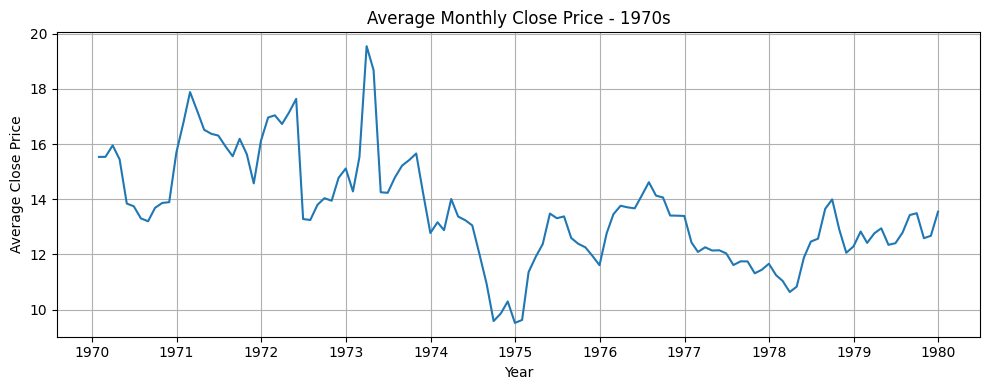

Saved figure: figures/monthly_close_1980s.png


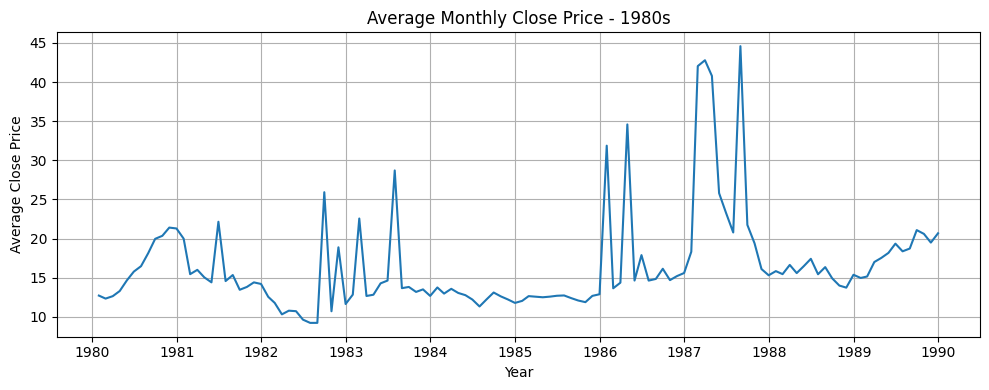

Saved figure: figures/monthly_close_1990s.png


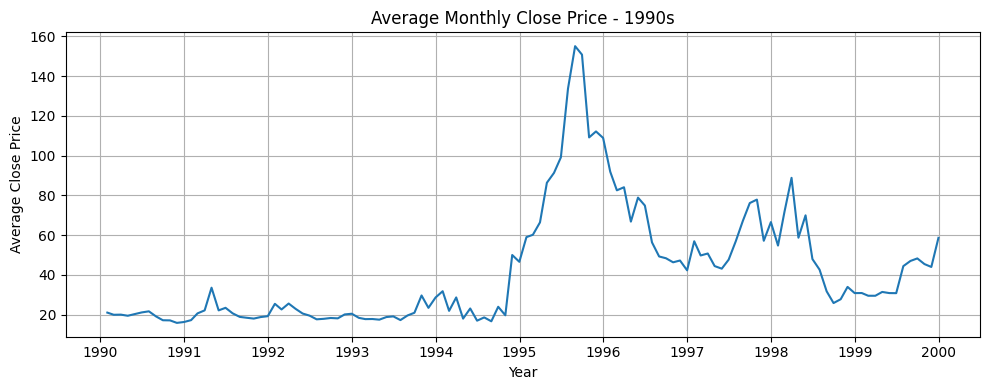

Saved figure: figures/monthly_close_2000s.png


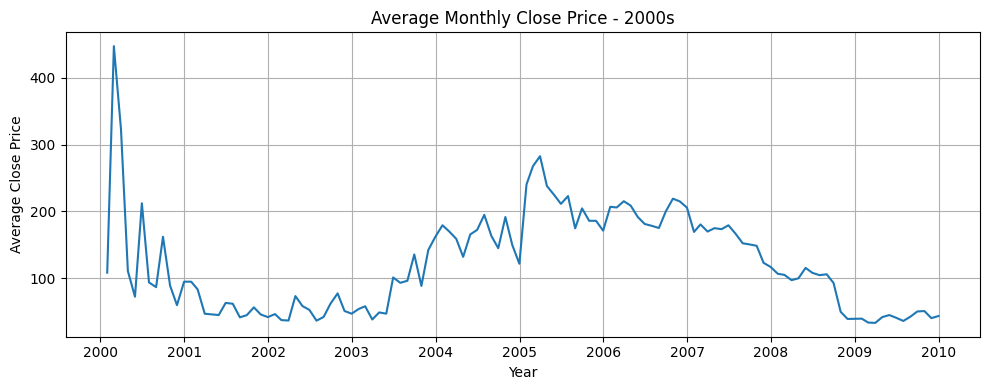

Saved figure: figures/monthly_close_2010s.png


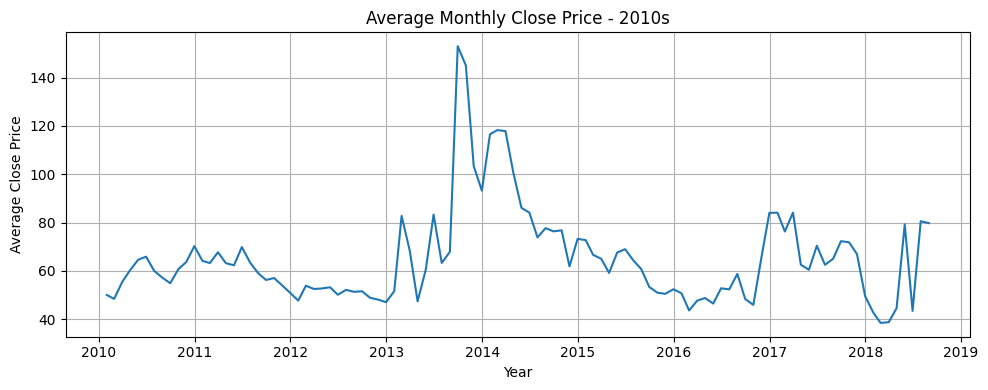


Plotting Volume histograms by decade...
Saved figure: figures/volume_hist_1970s.png


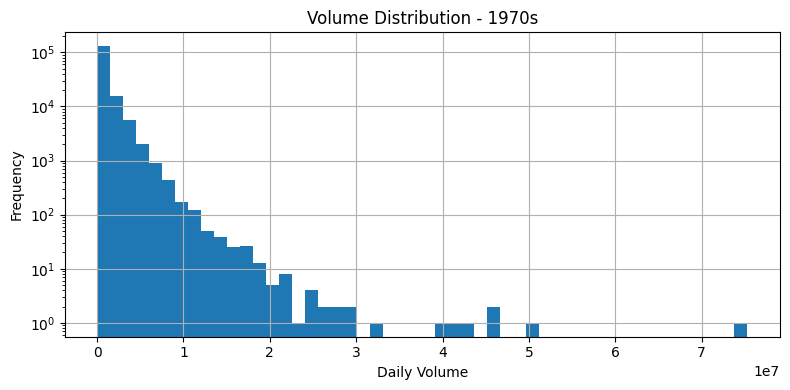

Saved figure: figures/volume_hist_1980s.png


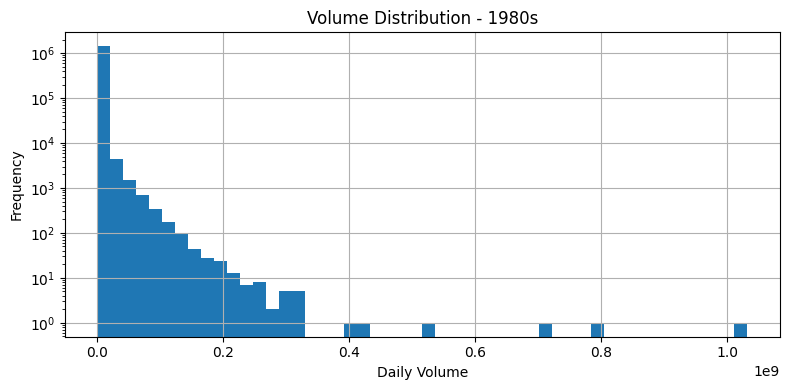

Saved figure: figures/volume_hist_1990s.png


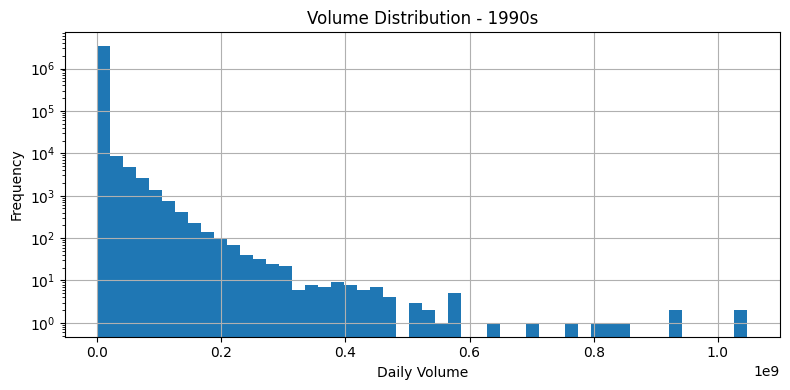

Saved figure: figures/volume_hist_2000s.png


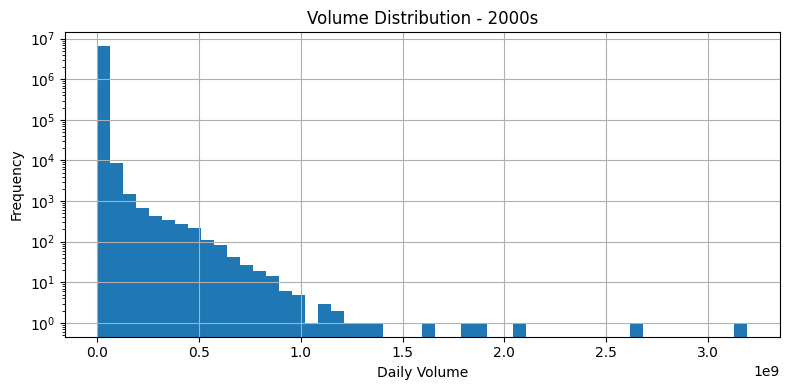

Saved figure: figures/volume_hist_2010s.png


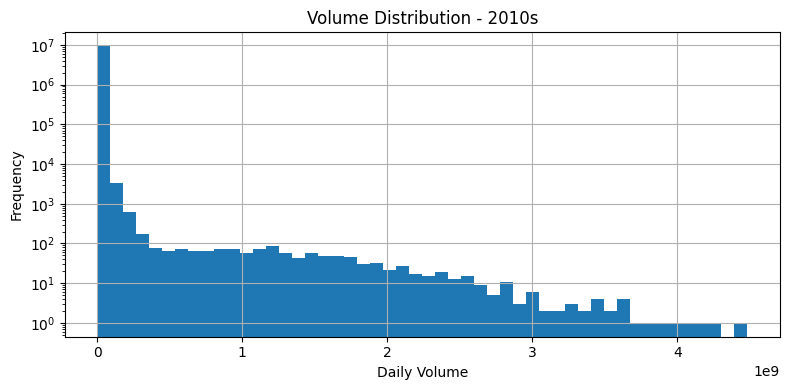


Plotting box plots for High and Low prices by decade...


/tmp/ipython-input-3607256661.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_high, labels=labels, showfliers=True)


Saved figure: figures/boxplot_high_by_decade.png


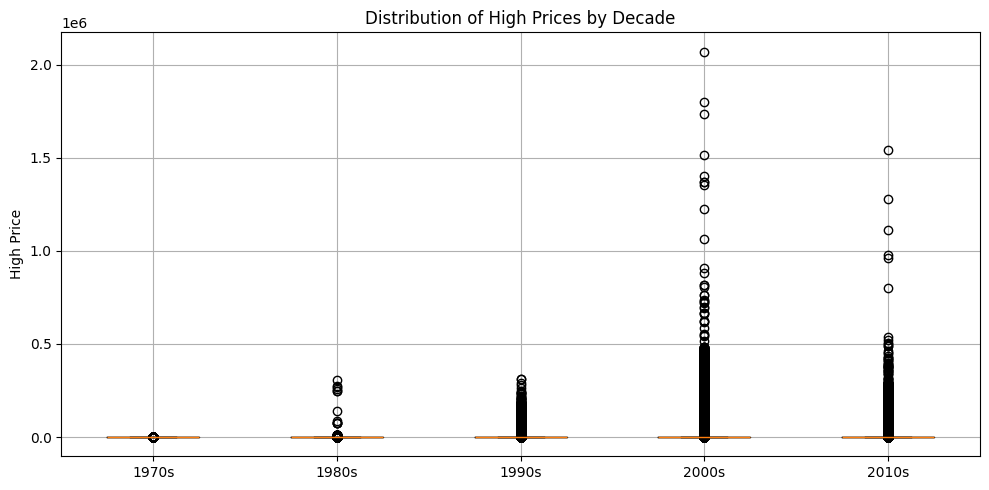

/tmp/ipython-input-3607256661.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_low, labels=labels, showfliers=True)


Saved figure: figures/boxplot_low_by_decade.png


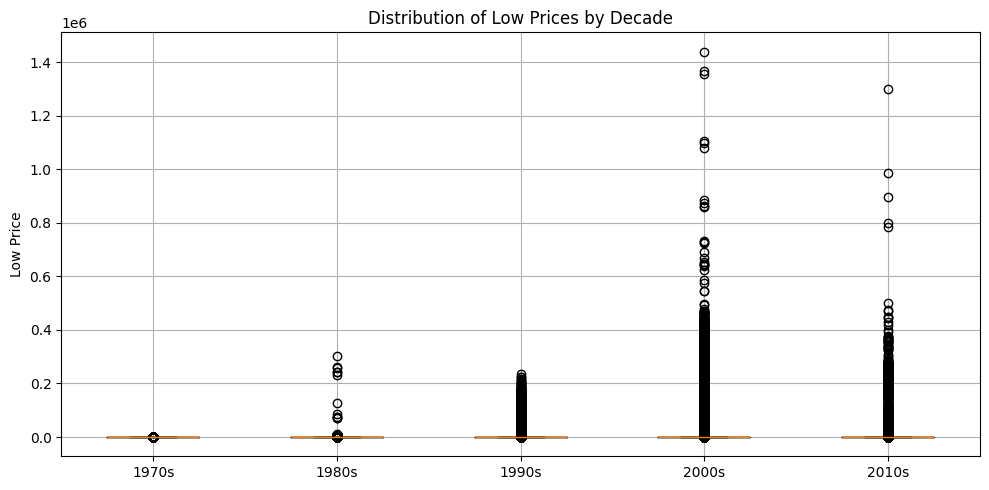

In [9]:
# 8. EDA Visualizations
# Utility to make figure saving optional
def maybe_save_fig(name: str):
    """
    Save the current pyplot figure into the FIG_DIR directory.
    """
    path = FIG_DIR / name
    plt.savefig(path, bbox_inches="tight")
    print(f"Saved figure: {path}")

# 8.1 Time series plots for average monthly Close by decade
print("\nPlotting average monthly Close price by decade...")

close_col = "close" if "close" in merged.columns else None
if close_col is None:
    raise ValueError("Expected a 'close' column for price data.")

for dec, df_dec in decade_dfs.items():
    monthly_close = df_dec[close_col].resample("M").mean()

    plt.figure(figsize=(10, 4))
    plt.plot(monthly_close)
    plt.title(f"Average Monthly Close Price - {dec}s")
    plt.xlabel("Year")
    plt.ylabel("Average Close Price")
    plt.grid(True)
    plt.tight_layout()
    maybe_save_fig(f"monthly_close_{dec}s.png")
    plt.show()

# 8.2 Histograms for Volume by decade
print("\nPlotting Volume histograms by decade...")

volume_col = "volume" if "volume" in merged.columns else None
if volume_col is None:
    raise ValueError("Expected a 'volume' column for the volume data.")

for dec, df_dec in decade_dfs.items():
    plt.figure(figsize=(8, 4))
    plt.hist(df_dec[volume_col], bins=50)
    plt.title(f"Volume Distribution - {dec}s")
    plt.xlabel("Daily Volume")
    plt.ylabel("Frequency")
    plt.yscale("log")  # optional: volume is often very skewed
    plt.grid(True)
    plt.tight_layout()
    maybe_save_fig(f"volume_hist_{dec}s.png")
    plt.show()

# 8.3 Box plots for High and Low prices by decade
print("\nPlotting box plots for High and Low prices by decade...")

high_col = "high" if "high" in merged.columns else None
low_col = "low" if "low" in merged.columns else None

if high_col is None or low_col is None:
    raise ValueError("Expected 'high' and 'low' columns for price data.")

# High price box plots
plt.figure(figsize=(10, 5))
data_high = [df_dec[high_col] for dec, df_dec in sorted(decade_dfs.items())]
labels = [f"{dec}s" for dec in sorted(decade_dfs.keys())]

plt.boxplot(data_high, labels=labels, showfliers=True)
plt.title("Distribution of High Prices by Decade")
plt.ylabel("High Price")
plt.grid(True)
plt.tight_layout()
maybe_save_fig("boxplot_high_by_decade.png")
plt.show()

# Low price box plots
plt.figure(figsize=(10, 5))
data_low = [df_dec[low_col] for dec, df_dec in sorted(decade_dfs.items())]
labels = [f"{dec}s" for dec in sorted(decade_dfs.keys())]

plt.boxplot(data_low, labels=labels, showfliers=True)
plt.title("Distribution of Low Prices by Decade")
plt.ylabel("Low Price")
plt.grid(True)
plt.tight_layout()
maybe_save_fig("boxplot_low_by_decade.png")
plt.show()

In [10]:
# 9. Sector-level summary (if sector exists)
if "sector" in merged.columns:
    print("\nCalculating summary statistics by decade and sector...")
    summary_by_decade_sector = (
        merged.groupby(["decade", "sector"])[summary_cols]
        .agg(["mean", "median", "std"])
        .round(2)
    )
    summary_by_decade_sector.to_csv("summary_by_decade_sector.csv")
    print("Saved summary_by_decade_sector.csv")
else:
    print("\nNo 'sector' column found in stocks. Skipping sector-level summaries.")


print("\nAll steps completed. Use the printed tables and saved figures when writing your report.")



Calculating summary statistics by decade and sector...
Saved summary_by_decade_sector.csv

All steps completed. Use the printed tables and saved figures when writing your report.


In [11]:
# Save cleaned, merged dataset for Project 2
merged.to_csv("merged_prices_with_sector.csv")
print("Saved merged dataset as merged_prices_with_sector.csv")


Saved merged dataset as merged_prices_with_sector.csv
